**Table of contents**<a id='toc0_'></a>    
- [移動ロボットによるライントレース](#toc1_)    
- [pybulletの起動](#toc2_)    
- [初期設定](#toc3_)    
- [シミュレーション実行](#toc4_)    
- [おまけ：ライントレース用の画像生成](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[移動ロボットによるライントレース](#toc0_)

本notebookでは2輪の移動ロボットのボトムカメラを使用したライントレースのシミュレーションを行います。

（pybulletで使用可能な関数がまとめられたマニュアルについては[こちら](https://github.com/bulletphysics/bullet3/blob/master/docs/pybullet_quickstartguide.pdf)を参照してください。）

# <a id='toc2_'></a>[pybulletの起動](#toc0_)

pybulletを起動します。

In [1]:
import time
import math
import pybullet
import pybullet_data
physics_client = pybullet.connect(pybullet.GUI) 

pybullet build time: Nov 28 2023 23:45:17


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Mesa
GL_RENDERER=llvmpipe (LLVM 15.0.7, 256 bits)
GL_VERSION=4.5 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
GL_SHADING_LANGUAGE_VERSION=4.50
pthread_getconcurrency()=0
Version = 4.5 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
Vendor = Mesa
Renderer = llvmpipe (LLVM 15.0.7, 256 bits)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


# <a id='toc3_'></a>[初期設定](#toc0_)

床の生成、ボックスオブジェクトの生成、ロボットの生成、カメラ位置の設定などの初期設定を行います。

なお、ライントレースのコースは、`loadTexture`関数でライントレース用の画像を読み込み、`changeVisualShape`関数で床に張り付けることで生成しています。  

そのため、`loadTexture`関数の引数に指定する画像を変更することで、ライントレースのコースを変更することができます。（ライントレース用の画像生成については「[おまけ：ライントレース用の画像生成](#toc3_)」を参照してください。）


In [2]:
pybullet.resetSimulation() # シミュレーション空間をリセット
pybullet.setAdditionalSearchPath(pybullet_data.getDataPath()) # pybulletに必要なデータへのパスを追加
pybullet.setGravity(0.0, 0.0, -9.8) # 地球上における重力に設定
time_step = 1./240.
pybullet.setTimeStep(time_step)

#床の読み込み
plane_id = pybullet.loadURDF("plane.urdf",  basePosition=[8.0, 4.5, 0.0], globalScaling=5.0)
tex_uid = pybullet.loadTexture("../texture/line_trace_ground.png")
pybullet.changeVisualShape(plane_id, -1, textureUniqueId=tex_uid)

# ロボットの読み込み
car_start_pos = [0.0, 0.0, 0.1]  # 初期位置(x,y,z)を設定
car_start_orientation = pybullet.getQuaternionFromEuler([0, 0, 0])  # 初期姿勢(roll, pitch, yaw)を設定
car_id = pybullet.loadURDF("../urdf/simple_two_wheel_car.urdf",car_start_pos, car_start_orientation)

# GUIモードの際のカメラの位置などを設定
camera_distance = 6.0
camera_yaw = 0.0 # deg
camera_pitch = -90.1 # deg
# cameraTargetPosition = [4.0, 0.0, 0.0]
camera_target_position = [2.5, 0.0, 0.0]
pybullet.resetDebugVisualizerCamera(camera_distance, camera_yaw, camera_pitch, camera_target_position)

ven = Mesa
ven = Mesa


# <a id='toc4_'></a>[シミュレーション実行](#toc0_)

シミュレーションでは、以下の手順でライントレースを行います。

1. ボトムカメラからラインの画像を取得
2. 画像処理によりラインの重心を求める
3. 重心の位置に応じてP制御によりロボットの両車輪の速度を調整
   - 具体的には、「画像中心位置（x方向）」と「ラインの重心位置（x方向）」の差が大きいほど、左または右に大きく曲がるように速度を調整します。

In [3]:
# 移動ロボットの動作に合わせて、cameraUpVectorを計算するために使用する回転行列を定義
def Rx(theta):
    return np.array([[1, 0, 0],
                     [0, np.cos(theta), -np.sin(theta)],
                     [0, np.sin(theta), np.cos(theta)]])

def Ry(theta):
    return np.array([[np.cos(theta), 0, np.sin(theta)],
                     [0, 1, 0],
                     [-np.sin(theta), 0, np.cos(theta)]])

def Rz(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta), np.cos(theta), 0],
                     [0, 0, 1]])

In [4]:
import numpy as np
import cv2

# ロボットを初期位置にセット
car_start_pos = [0.0, 0, 0.1]
car_start_orientation = pybullet.getQuaternionFromEuler([0.0, 0.0, -math.pi/2])
pybullet.resetBasePositionAndOrientation(car_id, car_start_pos, car_start_orientation)

# 時刻設定
time_length = 10000

# ボトムカメラの設定
projection_matrix = pybullet.computeProjectionMatrixFOV(fov=140.0,aspect=1.0,nearVal=0.04,farVal=100)
    
# リンクのインデックス
CAMERA_IDX = 8
CAMERA_TARGET_IDX = 9

# ジョイントのインデックス
RIGHT_WHEEL_JOINT_IDX = 0
LEFT_WHEEL_JOINT_IDX = 1

# P制御のパラメータ
Kp = 0.1

# 車輪の基本速度
base_speed = 30

# camera_up_vectorのデフォルトの方向
camera_up_vector = np.array([0, -1, 0])

for t in range (time_length):
    # 1. ロボット下部のカメラセンサからラインの画像を取得 ##########################################################
    # カメラリンクの位置を取得
    camera_link_pose = pybullet.getLinkState(car_id, CAMERA_IDX)[0]

    # 注視点用の仮想的なリンクの位置を取得
    camera_target_link_pose = pybullet.getLinkState(car_id, CAMERA_TARGET_IDX)[0] 

    # cameraUpVectorを移動ロボットの姿勢に合わせて回転
    mobile_robot_roll, mobile_robot_pitch, mobile_robot_yaw = pybullet.getEulerFromQuaternion(pybullet.getLinkState(car_id, CAMERA_IDX)[1])
    R = Rz(np.deg2rad(90.0) + mobile_robot_yaw)@Ry(mobile_robot_pitch)@Rx(mobile_robot_roll)
    rotate_camera_up_vector = R@camera_up_vector

    # カメラリンク -> 注視点用の仮想的なリンク 方向のviewMatrixを取得
    view_matrix = pybullet.computeViewMatrix(cameraEyePosition=[camera_link_pose[0], camera_link_pose[1], camera_link_pose[2]],cameraTargetPosition=[camera_target_link_pose[0], camera_target_link_pose[1], camera_target_link_pose[2]],cameraUpVector=[rotate_camera_up_vector[0], rotate_camera_up_vector[1], rotate_camera_up_vector[2]])
    
    # ラインの画像を取得
    # renderer=pybullet.ER_BULLET_HARDWARE_OPENGLを指定することで、画質は下がる分高速に画像を取得できる
    width, height, rgb_img, depth_img, seg_img = pybullet.getCameraImage(600,300, view_matrix, projection_matrix, renderer=pybullet.ER_BULLET_HARDWARE_OPENGL)
    ############################################################################################################

    # 2. 画像処理（ラインの重心位置を計算） ########################################################################
    # 画像の2値化
    img = np.reshape(rgb_img, (height, width, 4))  # 取得した画像を4チャンネルのnumpy配列に変換
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)  # RGBAからRGBに変換
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # グレースケール化
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV) # 2値化

    # 重心を計算（参考：https://imagingsolution.net/program/python/opencv-python/opencv_moments_weight_center/）
    moments = cv2.moments(binary) 
    if moments["m00"] == 0: # ゼロ除算を防ぐための処理
        cx = width / 2
    else:
        cx = moments["m10"] / moments["m00"]
    ############################################################################################################

    # 3.ラインの重心位置に応じて、P制御により車輪の速度を調整 #################################################
    # P制御
    error = cx - (width / 2) # 「画像中心（x方向）」から「ラインの重心（x方向）」までの距離。ずれが大きいほど大きく右または左に曲がる
    output = Kp * error

    # 車輪の速度を調整
    right_speed = base_speed - output
    left_speed = base_speed + output

    # 車輪の速度を設定
    pybullet.setJointMotorControl2(car_id, RIGHT_WHEEL_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=right_speed)
    pybullet.setJointMotorControl2(car_id, LEFT_WHEEL_JOINT_IDX, pybullet.VELOCITY_CONTROL, targetVelocity=left_speed)
    ############################################################################################################

    # 一時刻分、シミュレーションを進める
    pybullet.stepSimulation()
    time.sleep(time_step)

# <a id='toc5_'></a>[おまけ：ライントレース用の画像生成](#toc0_)

以下コードを実行すると、ランダムなライントレース用のコースを生成することができます。

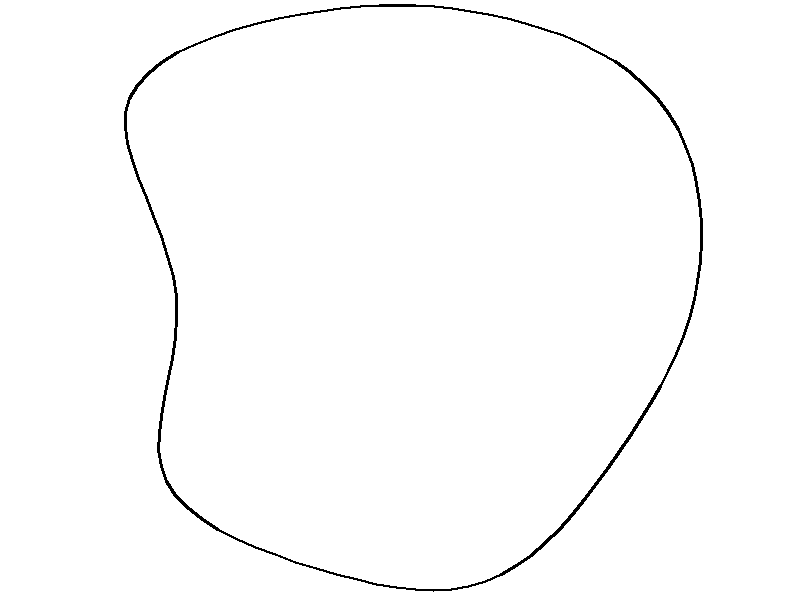

In [ ]:
from PIL import Image, ImageDraw
import numpy as np
from scipy.interpolate import splprep, splev

def generate_random_closed_curve_image(width, height, num_points=10, line_thickness=10, offset_range=1):
    # ランダムな制御点を生成
    center_x, centerY = width // 2, height // 2
    radius = min(center_x, centerY) - line_thickness * 2
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    random_offsets = np.random.uniform(-offset_range, offset_range, num_points)
    
    points = []
    for i, angle in enumerate(angles):
        for _ in range(100):  # 最大試行回数を設定
            r_offset = random_offsets[i] * radius / 4
            new_x = center_x + (radius + r_offset) * np.cos(angle)
            new_y = centerY + (radius + r_offset) * np.sin(angle)
            if line_thickness <= new_x <= width - line_thickness and line_thickness <= new_y <= height - line_thickness:
                points.append((new_x, new_y))
                break
        else:
            # 制御点の生成が失敗した場合、デフォルトの安全なポイントを追加
            new_x = center_x + radius * np.cos(angle)
            new_y = centerY + radius * np.sin(angle)
            points.append((new_x, new_y))
    
    # スタート位置を固定
    fixed_start_point = (center_x + radius * np.cos(0), centerY + radius * np.sin(0))
    points[0] = fixed_start_point
    
    # 曲線を閉じるために最初の点を最後に追加
    points.append(points[0])
    
    # 制御点をスムージング
    points = np.array(points)
    tck, u = splprep(points.T, s=0, per=True)
    u_new = np.linspace(u.min(), u.max(), num_points * 10)
    smooth_points = splev(u_new, tck)
    
    # 画像を作成
    image = Image.new('RGB', (width, height), 'white')
    draw = ImageDraw.Draw(image)
    
    # スムージングされた曲線を描画
    smooth_points = list(zip(smooth_points[0], smooth_points[1]))
    draw.line(smooth_points, fill='black', width=line_thickness)
    
    return image

# 画像のサイズと線の太さを指定
width, height, line_thickness = 800, 600, 3
offset_range = 1.0  # オフセットの範囲を調整
image = generate_random_closed_curve_image(width, height, num_points=10, line_thickness=line_thickness, offset_range=offset_range)

# 画像を保存
image.save('../texture/random_line_trace_ground.png')

# 画像を表示
image.show()
